# Prediction of sales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn as skl
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

In [2]:
#Kaggle divides the dataset already into Train and Test data
train = pd.read_csv(r"C:\Users\abdullah-laptop\Documents\Data Test\train.csv")
test = pd.read_csv(r"C:\Users\abdullah-laptop\Documents\Data Test\test.csv")

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [13]:
# understanding how many unique values i have
for col_name in train.columns:
    print(col_name, len(train[col_name].unique()))

User_ID 5891
Product_ID 3631
Gender 2
Age 7
Occupation 21
City_Category 3
Stay_In_Current_City_Years 5
Marital_Status 2
Product_Category_1 20
Product_Category_2 18
Product_Category_3 16
Purchase 18105


In [14]:
# getting the values of every unique entry from the following possible features 
for col_name in ['Gender', 'Age', 'Occupation', 'City_Category','Stay_In_Current_City_Years','Marital_Status']:
    print(sorted(train[col_name].unique()))

['F', 'M']
['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
['A', 'B', 'C']
['0', '1', '2', '3', '4+']
[0, 1]


In [15]:
# checking if unique users have same information in all of their enteries 
temp = train.drop_duplicates('User_ID')
print(temp.count())
df2 = train.drop(['Purchase','Product_ID','Product_Category_1','Product_Category_2','Product_Category_3'], axis=1)
df3 = df2.drop_duplicates()
df3.count()

User_ID                       5891
Product_ID                    5891
Gender                        5891
Age                           5891
Occupation                    5891
City_Category                 5891
Stay_In_Current_City_Years    5891
Marital_Status                5891
Product_Category_1            5891
Product_Category_2            4097
Product_Category_3            1914
Purchase                      5891
dtype: int64


User_ID                       5891
Gender                        5891
Age                           5891
Occupation                    5891
City_Category                 5891
Stay_In_Current_City_Years    5891
Marital_Status                5891
dtype: int64

# Descriptive analysis and Data Exploration 

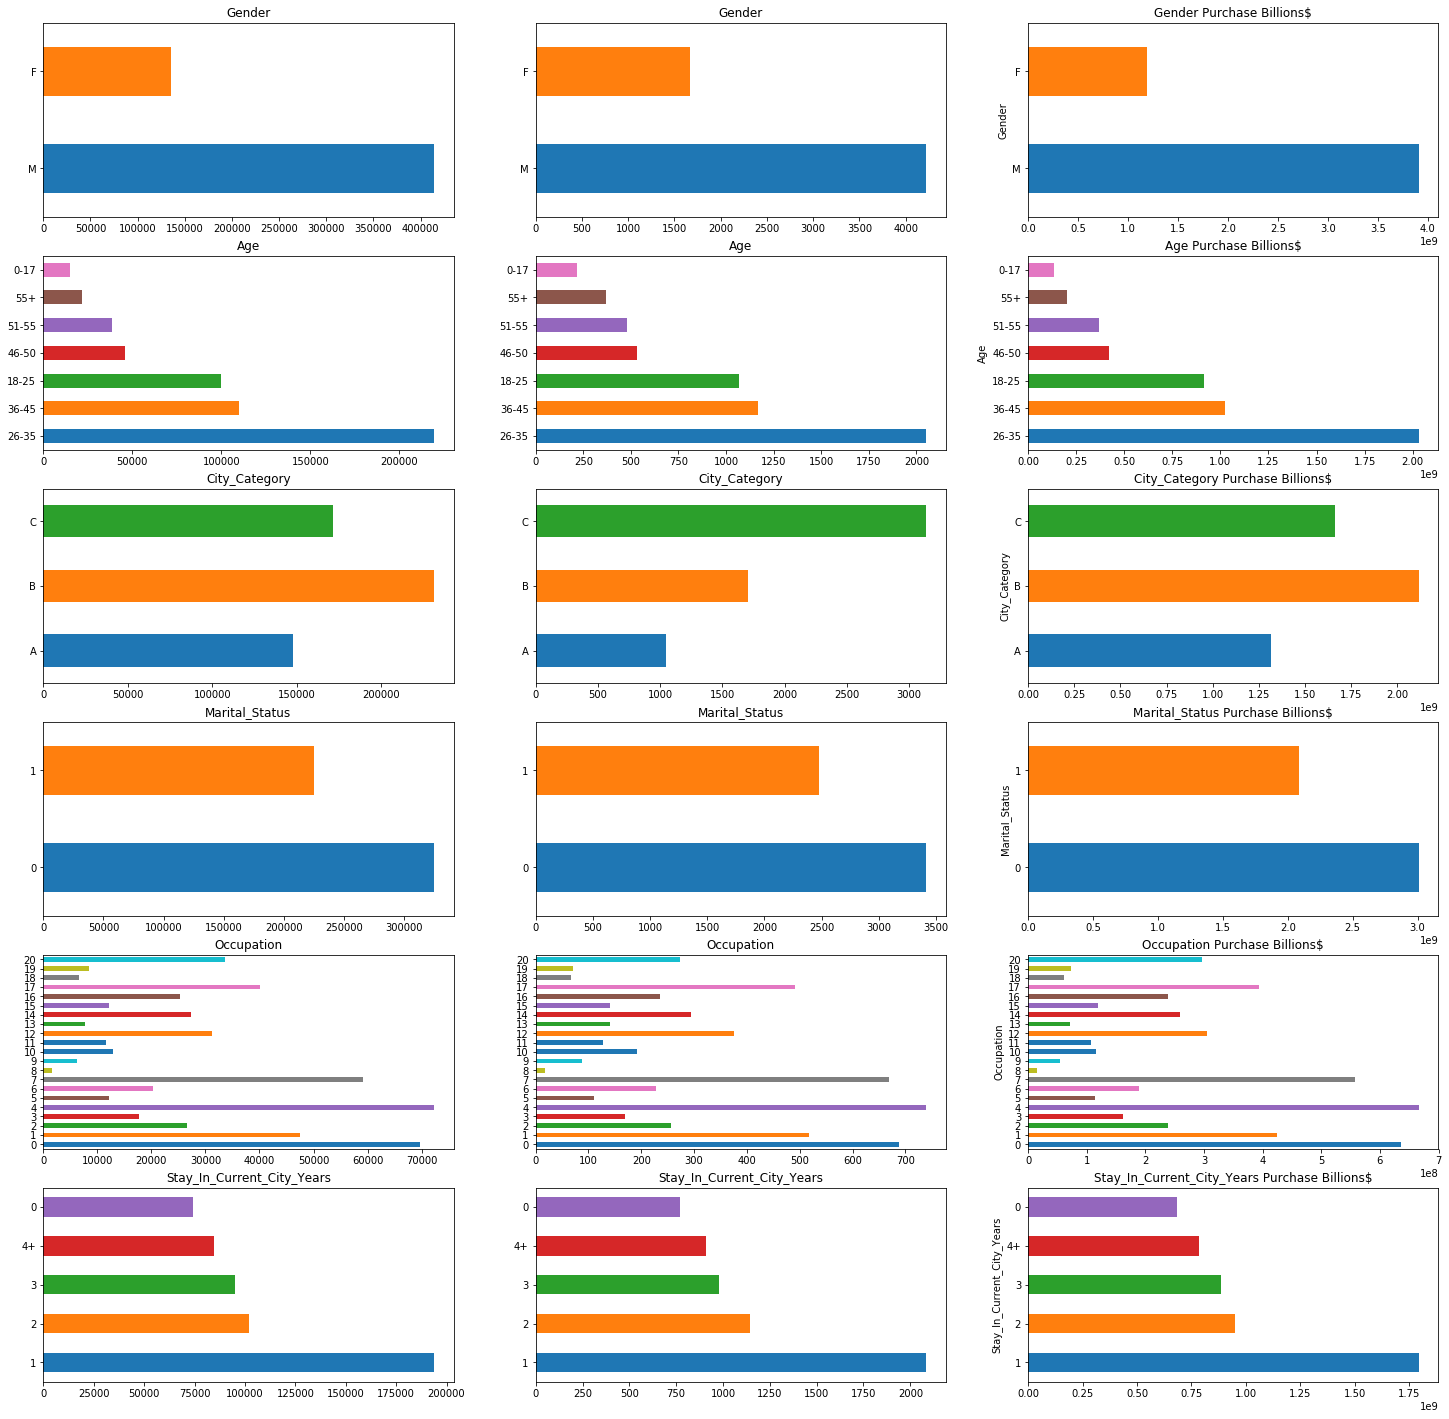

In [23]:
# lets compare the counts of entiers and unique users and the amount of purchases 
Train_unique= train.drop_duplicates('User_ID')
# Second for each unique group, we do a group by to sum the purchase amount
dfGender = train.groupby(['Gender'])['Purchase'].sum()
dfage = train.groupby(['Age'])['Purchase'].sum()
dfoccu = train.groupby(['Occupation'])['Purchase'].sum()
dfCC = train.groupby(['City_Category'])['Purchase'].sum()
dfstay = train.groupby(['Stay_In_Current_City_Years'])['Purchase'].sum()
dfM = train.groupby(['Marital_Status'])['Purchase'].sum()


fig, axes = plt.subplots(nrows=6, ncols=3, figsize=[25, 25])

# count of eneries 
train['Gender'].value_counts().plot(kind='barh', ax=axes[0,0], title='Gender')
train['Age'].value_counts().plot(kind='barh', ax=axes[1,0], title='Age')
train['City_Category'].value_counts().sort_index().plot(kind='barh', ax=axes[2,0], title='City_Category')
train['Marital_Status'].value_counts().plot(kind='barh', ax=axes[3,0], title='Marital_Status')
train['Occupation'].value_counts().sort_index().plot(kind='barh', ax=axes[4,0], title='Occupation')
train['Stay_In_Current_City_Years'].value_counts().plot(kind='barh', ax=axes[5,0], title='Stay_In_Current_City_Years')
# unique user count
Train_unique['Gender'].value_counts().plot(kind='barh', ax=axes[0,1], title='Gender')
Train_unique['Age'].value_counts().plot(kind='barh', ax=axes[1,1], title='Age')
Train_unique['City_Category'].value_counts().sort_index().plot(kind='barh', ax=axes[2,1], title='City_Category')
Train_unique['Marital_Status'].value_counts().plot(kind='barh', ax=axes[3,1], title='Marital_Status')
Train_unique['Occupation'].value_counts().sort_index().plot(kind='barh', ax=axes[4,1], title='Occupation')
Train_unique['Stay_In_Current_City_Years'].value_counts().plot(kind='barh', ax=axes[5,1], title='Stay_In_Current_City_Years')
# amount of purchaes 
dfGender.sort_values(ascending=False).plot(kind='barh', ax=axes[0,2], title='Gender Purchase Billions$')
dfage.sort_values(ascending=False).plot(kind='barh', ax=axes[1,2], title='Age Purchase Billions$')
dfCC.sort_index().plot(kind='barh', ax=axes[2,2], title='City_Category Purchase Billions$')
dfM.sort_values(ascending=False).plot(kind='barh', ax=axes[3,2], title='Marital_Status Purchase Billions$')
dfoccu.sort_index().plot(kind='barh', ax=axes[4,2], title='Occupation Purchase Billions$')
dfstay.sort_values(ascending=False).plot(kind='barh', ax=axes[5,2], title='Stay_In_Current_City_Years Purchase Billions$')


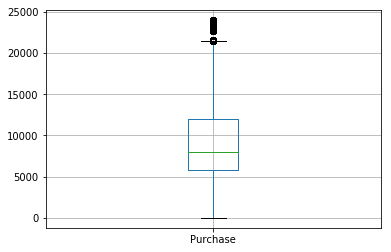

In [30]:
boxplot = train.boxplot(column='Purchase')

In [80]:
#finding outliers
Q1 = train['Purchase'].quantile(0.25)
Q3 = train['Purchase'].quantile(0.75)
IQR = Q3 - Q1
outliers=train[(train['Purchase'] < Q1-1.5*IQR ) | (train['Purchase'] > Q3+1.5*IQR)]['Purchase']
Outlier_index=outliers.reset_index().drop(['Purchase'], axis=1)
oil=Outlier_index["index"].tolist()
Purchase_outliers=train.loc[Outlier_index['index']]
train_nooutliers=train.drop(index=oil,axis=0)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
343,1000058,P00117642,M,26-35,2,B,3,0,10,16.0,NaN,23603
375,1000062,P00119342,F,36-45,3,A,1,0,10,13.0,NaN,23792
652,1000126,P00087042,M,18-25,9,B,1,0,10,14.0,16.0,23233
736,1000139,P00159542,F,26-35,20,C,2,0,10,15.0,16.0,23595
1041,1000175,P00052842,F,26-35,2,B,1,0,10,15.0,NaN,23341


# Pre-Processing 

In [4]:
#because i have categorical data in many columns i need to change them to dummy binary or int 
train['Product_Category_2']=train['Product_Category_2'].fillna(-2.0).astype("int64")
train['Product_Category_3']=train['Product_Category_3'].fillna(-2.0).astype("int64")
test['Product_Category_2']=test['Product_Category_2'].fillna(-2.0).astype("int64")
test['Product_Category_3']=test['Product_Category_3'].fillna(-2.0).astype("int64")

In [3]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#Turn gender binary
gender_dict = {'F':0, 'M':1}
train["Gender"] = train["Gender"].apply(lambda line: gender_dict[line])

In [5]:
# Giving Age Numerical values
age_dict = {'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6}
train["Age"] = train["Age"].apply(lambda line: age_dict[line])

In [6]:
city_dict = {'A':0, 'B':1, 'C':2}
train["City_Category"] = train["City_Category"].apply(lambda line: city_dict[line])

In [7]:
#New variable for outlet
train['Stay_In_Current_City_Years'] = le.fit_transform(train['Stay_In_Current_City_Years'])
#Dummy Variables:
train = pd.get_dummies(train, columns=['Stay_In_Current_City_Years'])

In [13]:
#Turn gender binary
gender_dict = {'F':0, 'M':1}
test["Gender"] = test["Gender"].apply(lambda line: gender_dict[line])
test["Gender"].value_counts()
# Giving Age Numerical values
age_dict = {'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6}
test["Age"] = test["Age"].apply(lambda line: age_dict[line])
test["Age"].value_counts()
city_dict = {'A':0, 'B':1, 'C':2}
test["City_Category"] = test["City_Category"].apply(lambda line: city_dict[line])
test["City_Category"].value_counts()
le = LabelEncoder()

In [18]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
test['Stay_In_Current_City_Years'] = le.fit_transform(test['Stay_In_Current_City_Years'])
#Dummy Variables:
test = pd.get_dummies(test, columns=['Stay_In_Current_City_Years'])
test.dtypes

User_ID                          int64
Product_ID                      object
Gender                           int64
Age                              int64
Occupation                       int64
City_Category                    int64
Marital_Status                   int64
Product_Category_1               int64
Product_Category_2               int64
Product_Category_3               int64
Stay_In_Current_City_Years_0     uint8
Stay_In_Current_City_Years_1     uint8
Stay_In_Current_City_Years_2     uint8
Stay_In_Current_City_Years_3     uint8
Stay_In_Current_City_Years_4     uint8
dtype: object

# model fit 

In [20]:
#Define target and ID columns:
target = 'Purchase'
IDcol = ['User_ID','Product_ID']
from sklearn.model_selection import cross_val_score
from sklearn import metrics

def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_val_score(alg, dtrain[predictors],(dtrain[target]) , cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error((dtrain[target]).values, dtrain_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv("out.csv", index=False)

# Model Selection


Model Report
RMSE : 4622
CV Score : Mean - 4625 | Std - 33.24 | Min - 4557 | Max - 4680


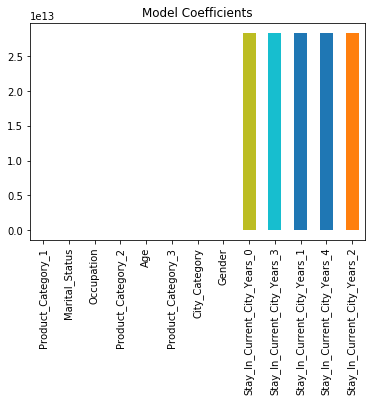

In [21]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression(normalize=True)

predictors = train.columns.drop(['Purchase','Product_ID','User_ID'])
modelfit(LR, train, test, predictors, target, IDcol, 'LR.csv')

coef1 = pd.Series(LR.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')


Model Report
RMSE : 2966
CV Score : Mean - 2980 | Std - 19.5 | Min - 2941 | Max - 3012


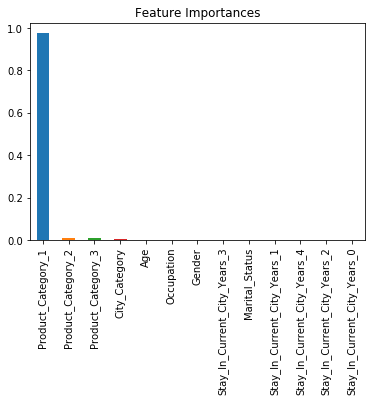

In [23]:
from sklearn.tree import DecisionTreeRegressor
RF = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(RF, train, test, predictors, target, IDcol, 'RF.csv')

coef4 = pd.Series(RF.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

In [ ]:
import xgboost as xgb
train=train.drop(['Purchase','Product_ID'], axis=1)
dtrain = xgb.DMatrix(train.values, label=target, missing=np.nan)
num_round = 690
param = {'objective': 'reg:linear', 'booster': 'gbtree', 'silent': 1,
		 'max_depth': 10, 'eta': 0.1, 'nthread': 4,
		 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 20,
		 'max_delta_step': 0, 'gamma': 0}

clf = xgb.train(param, dtrain, num_round)
modelfit(clf, train, test, predictors, target, IDcol, 'RF.csv')

coef1 = pd.Series(xgb.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')